In [1]:
import seaborn as sns
# sns.set()
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def SMA(series, size: int = 20) -> list: 
    averaged = []
    for i in range(len(series)+size-1):
        window = series[i:i+size]
        averaged.append(np.mean(window))
    return averaged

## Reference Implementation (Policy Iteration)

  9%|▉         | 9/100 [00:21<03:34,  2.36s/it]

breaking
59 calls of Policy Evaluation/Improvement (each involving a loop over 110 states)


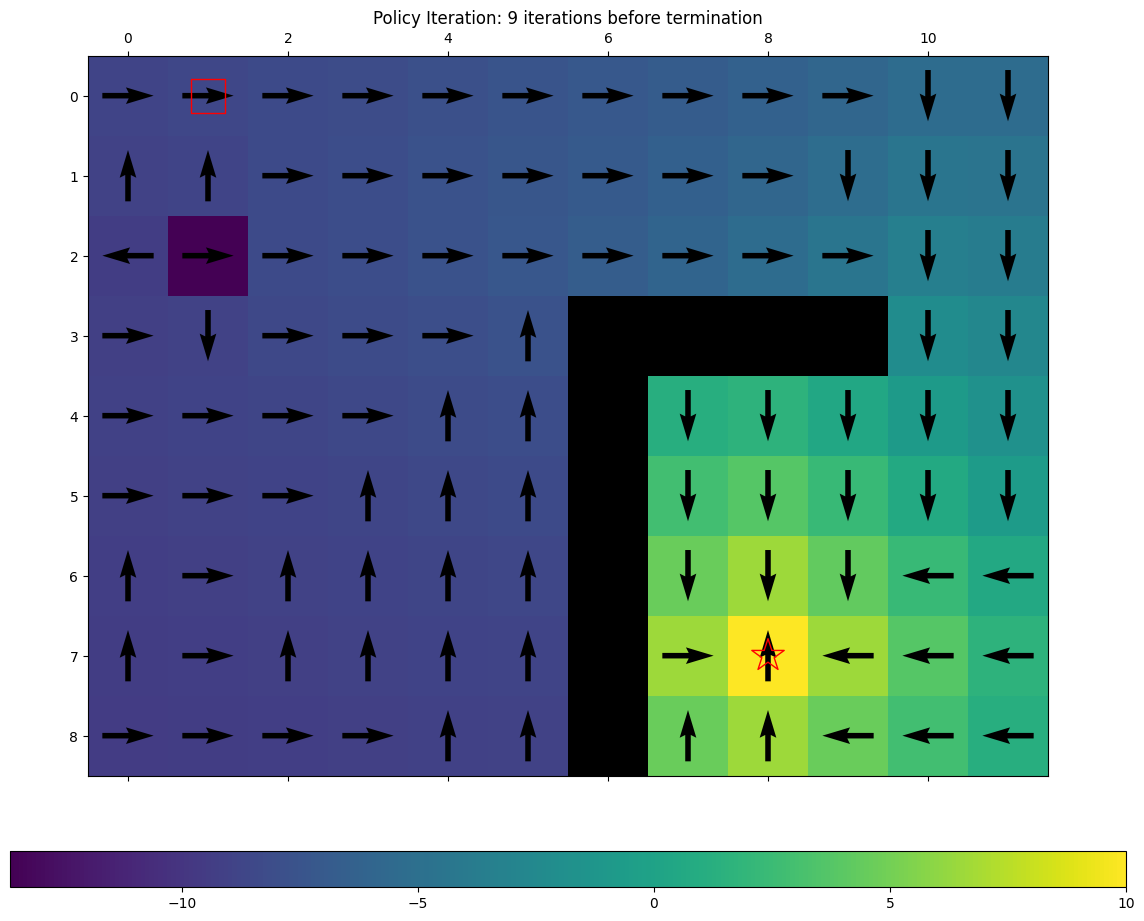

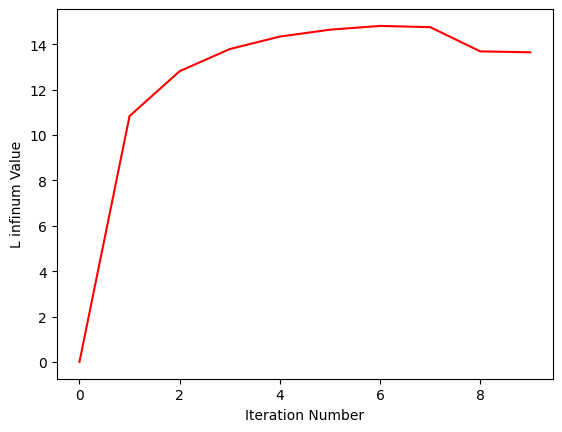

109


In [80]:
from cgitb import small
from typing import Callable
from matplotlib.pyplot import grid
from tqdm import tqdm
import numpy as np

from model import Model, Actions


def policy_iteration(model: Model, maxit: int = 100):

    V = np.zeros((model.num_states,))
    pi = np.zeros((model.num_states,))
    count = 0 # count of calls of policy evalutation

    def compute_value(s, a, reward: Callable):
        return np.sum(
            [
                model.transition_probability(s, s_, a)
                * (reward(s, a) + model.gamma * V[s_])
                for s_ in model.states
            ]
        )

    def policy_evaluation():
        for s in model.states:
            R = model.reward(s, pi[s])
            V[s] = compute_value(s, pi[s], lambda *_: R)

    def policy_improvement():
        for s in model.states:
            action_index = np.argmax(
                [compute_value(s, a, model.reward) for a in Actions]
            )
            pi[s] = Actions(action_index)

    l_inf = []
    for i in tqdm(range(maxit)):
        l_inf.append(np.max(abs(V)))
        for _ in range(5):
            policy_evaluation()
            count += 1
        pi_old = np.copy(pi)
        policy_improvement()
        if all(pi_old == pi):
            print("breaking")
            break

    print(f'{count+i} calls of Policy Evaluation/Improvement (each involving a loop over {len(model.states)+1} states)')
    return V, pi, i, l_inf


if __name__ == "__main__":
    import matplotlib.pyplot as plt
    from world_config import cliff_world, small_world, grid_world
    from plot_vp import plot_vp

    maxit = 100
    world = {'cliffworld': cliff_world, 'gridworld': grid_world, 'smallworld': small_world}
    choice = 'gridworld'
    model = Model(world[choice])
    V, pi, i, mean_values = policy_iteration(model)
    plot_vp(model, V, pi, title=f'Policy Iteration: {i} iterations before termination')
    plt.savefig('Results/policy_iteration_'+str(choice)+'.png', bbox_inches='tight')
    plt.show()
    
    # To show similarity between Policy and Value iteration's convergences (and that they converge) - NOT to show the model working well, etc...
    plt.plot(mean_values, 'r')
    # plt.title('Policy Iteration Mean Values per Iteration')
    plt.xlabel('Iteration Number')
    plt.ylabel('L infinum Value')
    # plt.ylim(-20, 0)
    plt.savefig(f'Results/Policy_iteration_mean_values_{choice}.png', bbox_inches='tight')
    plt.show()
    print(model.num_states)

## Part A: (Value Iteration)

In [157]:
from cgitb import small
from typing import Callable
from matplotlib.pyplot import grid
from tqdm import tqdm, trange
import numpy as np
from model import Model, Actions

In [82]:
def Asynchronous_value_iteration(model: Model, maxit: int = 100, threshold: float = 0.1):
    
    ## Initialise:
    V = np.zeros((model.num_states))
    pi = np.zeros((model.num_states))
    count = 0

    ## Compute the value of being in the current state with the current action by taking expectation of value over next states that the action can take you to:
    def compute_value(s, a, reward: Callable):
        return np.sum([model.transition_probability(s, s_next, a) * (reward(s, a) + model.gamma * V[s_next]) for s_next in model.states])

    ## For each current state, find the value of each action using the compute_value, and greedily take the action with highest expected value:
    def update_values():
        for s in model.states:
            action_values = [compute_value(s, a, model.reward) for a in Actions]
            V[s] = np.max(action_values)

    # purely for the purpose of plot_vp and not required by this algorithm:
    def compute_policy():
        for s in model.states:
            action_index = np.argmax(
                [compute_value(s, a, model.reward) for a in Actions]
            )
            pi[s] = Actions(action_index)

    l_inf = []
    for i in trange(maxit):
        V_old = V.copy()
        l_inf.append(np.max(abs(V)))
        update_values()

        # purely for the purpose of plot_vp and not required by this algorithm:
        compute_policy()
        
        diff = max(abs(V_old-V))
        count += 1
        if diff < threshold:
            print("breaking")
            break

    print(f'{count+i} calls of Value Improvement (each involving a loop over {len(model.states)+1} states)')
    return V, i, l_inf, pi

 60%|██████    | 60/100 [02:20<01:33,  2.34s/it]

breaking
121 calls of Value Improvement (each involving a loop over 110 states)


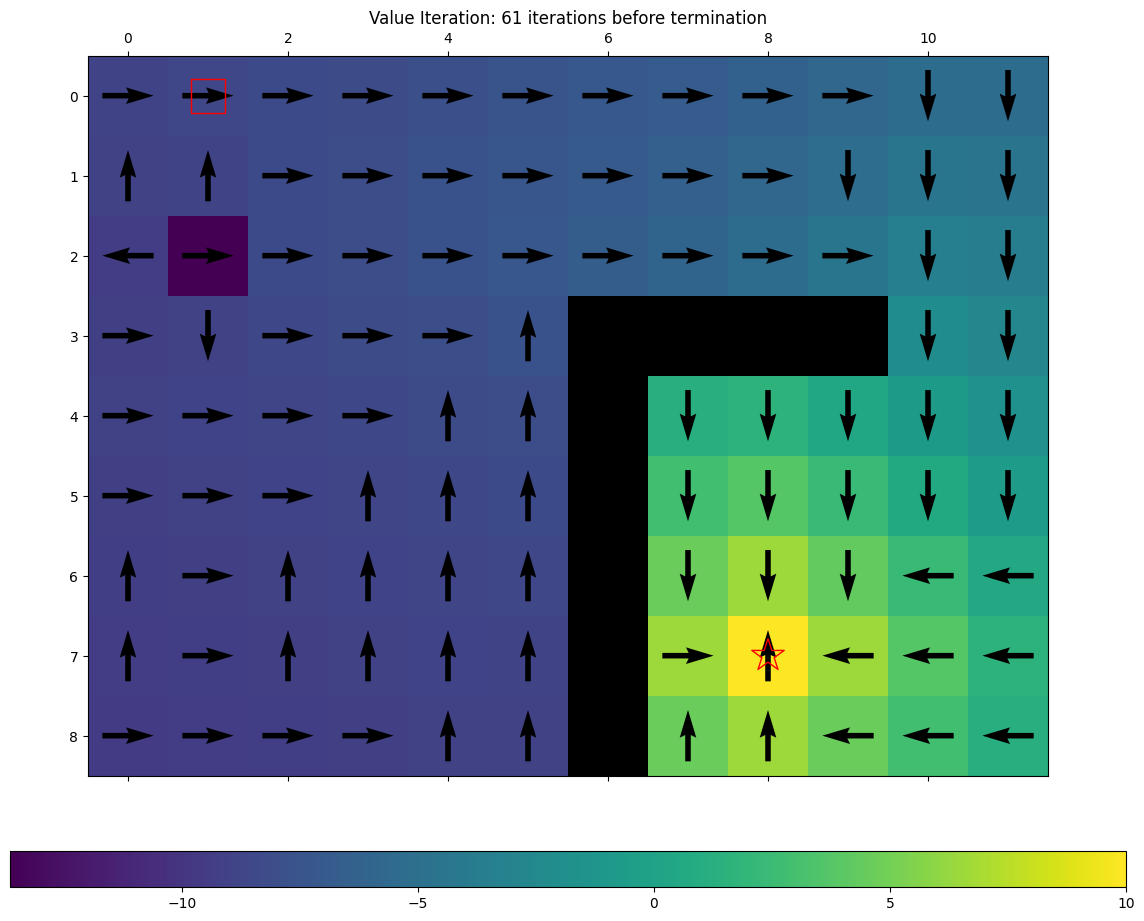

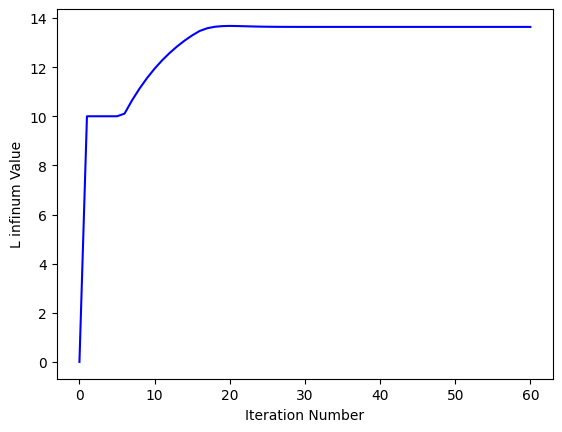

In [83]:
import matplotlib.pyplot as plt
from world_config import cliff_world, small_world, grid_world
from plot_vp import plot_vp

maxit = 100
world = {'cliffworld': cliff_world, 'gridworld': grid_world, 'smallworld': small_world}
choice = 'gridworld'
model = Model(world[choice])
V, i, l_inf, pi = Asynchronous_value_iteration(model, maxit, threshold = 1e-10)
plot_vp(model, V, pi, title=f'Value Iteration: {i+1} iterations before termination')
plt.savefig('Results/Asynchronous_value_iteration_'+str(choice)+'.png', bbox_inches='tight')
plt.show()

# To show similarity between Policy and Value iteration's convergences (and that they converge) - NOT to show the model working well, etc...
plt.plot(l_inf, 'b')
# plt.title('Asynchronous Value Iteration Mean Values per Iteration')
plt.xlabel('Iteration Number')
plt.ylabel(r'L infinum Value')
# plt.ylim(-20, 0)
plt.savefig(f'Results/Asynchronous_Value_iteration_mean_values_{choice}.png', bbox_inches='tight')
plt.show()

### Asynchronous vs Synchronous Value Iteration:

Syncrhonous: sweep through every state s in S for each update, and do not update the value (or policy for policy iteration) until the full sweep is completed

Asynchronous: Pick a state at random and apply the appropriate back-up. Advantage  of not getting stuck in very long sweeps when there are many states. It is still guaranteed to converge if all of the states continue to be selected up to an infinite number of times. Done, for example, by `in-place dynamic programming'.
- In this regime, we update the value for state s immediately within the loop over s in S (so this is boostrapping, as this updates value function is used to update the next state's entry)

- NB! To see the difference, observe the learned values of cells after a single iteration!

In [84]:
def SynchronousValueIteration(model: Model, maxit: int = 100, threshold: float = 0.1): #!! TODO: Finish
    
    ## Initialise:
    V = np.zeros((model.num_states))
    pi = np.zeros((model.num_states))
    count = 0

    ## Compute the value of being in the current state with the current action by taking expectation of value over next states that the action can take you to:
    def compute_value(s, a, reward: Callable):
        return np.sum([model.transition_probability(s, s_next, a) * (reward(s, a) + model.gamma * V[s_next]) for s_next in model.states])

    ## For each current state, find the value of each action using the compute_value, and greedily take the action with highest expected value:
    def update_values():
        V_new = V.copy()
        for s in model.states:
            action_values = [compute_value(s, a, model.reward) for a in Actions]
            V_new[s] = np.max(action_values)
        return V_new

    # purely for the purpose of plot_vp and not required by this algorithm:
    def compute_policy():
        for s in model.states:
            action_index = np.argmax(
                [compute_value(s, a, model.reward) for a in Actions]
            )
            pi[s] = Actions(action_index)

    l_inf = []
    for i in trange(maxit):
        l_inf.append(np.max(abs(V)))
        V_new = update_values()
        diff = max(abs(V_new-V))
        V = V_new

        # purely for the purpose of plott_vp and not required by this algorithm:
        compute_policy()

        count += 1
        if diff < threshold:
            print("breaking")
            break

    print(f'{count+i} calls of Value Improvement (each involving a loop over {len(model.states)+1} states)')
    return V, i, l_inf, pi

  1%|▏         | 13/1000 [00:04<05:50,  2.81it/s]

breaking
27 calls of Value Improvement (each involving a loop over 52 states)


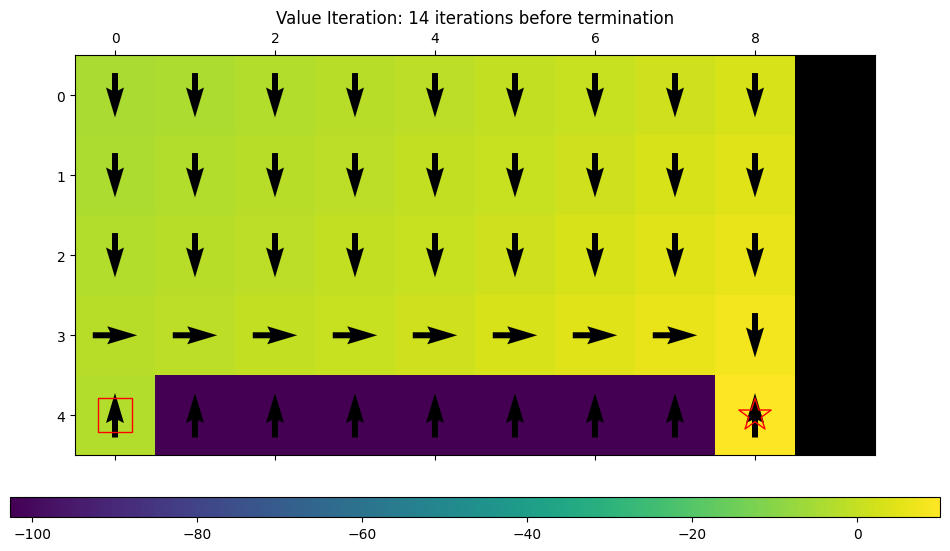

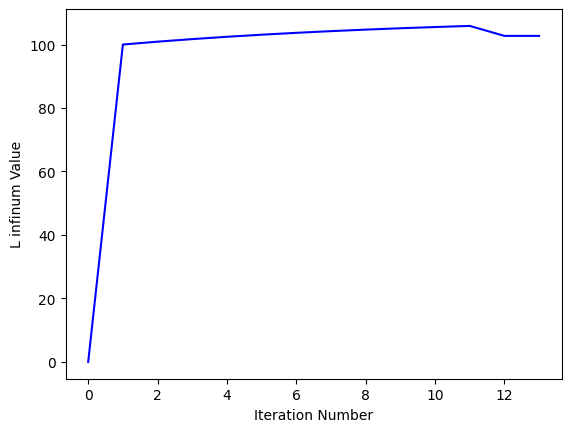

In [87]:
import matplotlib.pyplot as plt
from world_config import cliff_world, small_world, grid_world
from plot_vp import plot_vp

maxit = 1000
world = {'cliffworld': cliff_world, 'gridworld': grid_world, 'smallworld': small_world}
choice = 'cliffworld'
model = Model(world[choice])
V, i, l_inf, pi = SynchronousValueIteration(model, maxit, threshold = 1e-10)
plot_vp(model, V, pi, title=f'Value Iteration: {i+1} iterations before termination')
plt.savefig('Results/Synchronous_value_iteration_'+str(choice)+'.png', bbox_inches='tight')
plt.show()

# To show similarity between Policy and Value iteration's convergences (and that they converge) - NOT to show the model working well, etc...
plt.plot(l_inf, 'b')
# plt.title('Synchronous Value Iteration Mean Values per Iteration')
plt.xlabel('Iteration Number')
plt.ylabel('L infinum Value')
# plt.ylim(-20, 0)
plt.savefig(f'Results/Synchronous_Value_iteration_mean_values_{choice}.png', bbox_inches='tight')
plt.show()

## Part B: SARSA and ESARSA

In [4]:
from cgitb import small
from typing import Callable
from matplotlib.pyplot import grid
from tqdm import tqdm, trange
import numpy as np
from model import Model, Actions

### SARSA

In [52]:
def SARSA(model: Model, num_episodes: int = 100, maxit: int = 1000, alpha: float = 1, epsilon: float = 0.1, dynamic: bool = False, dynamic_alpha: bool = False):
    
    ## Initialise Q-func values and policy:
    Q = np.zeros((len(model.states), len(Actions)))
    V = np.zeros((len(model.states,)))
    pi = [Actions(0)] * len(model.states) # intialise policy actions from all states to 0 arbitrarily
    
    def choose_action(s: int, epsilon):
        if np.random.uniform(0,1) < epsilon:
            return np.random.randint(Q.shape[1])
        else:
            return np.argmax(Q[s])

    def update_Q(s, a, r, s_next, a_next, alpha):
        # SARSA has to input a_next as a_next is sampled eps-greedily (1 step forward, hence temporal difference):
        Q[s][a] += alpha * (r + model.gamma*Q[s_next, a_next] - Q[s][a])

    def update_pi(s):
        optimal_action_index = np.argmax(Q[s, :])
        pi[s] = Actions(optimal_action_index)

    # def record_V(s, a): 
        # V[s] = np.sum([model.transition_probability(s, s_, a) * (model.reward(s, a) + model.gamma * V[s_]) for s_ in model.states])

    episode_total_rewards = []
    threshold = 0.0001
    iterations = []

    for i in trange(num_episodes):

        pi_old = pi.copy()
        Q_old = Q.copy()
        episode_over = False
        cumulative_reward = 0
        s = model.start_state
        action = choose_action(s, epsilon=1) # first initialisation step greedy
        j = 0
        
        while not episode_over and j <= maxit:
            # by putting dynamic epsilon here, the agent becomes more certain WITHIN AN EPISODE rather than over many episodes
            if not dynamic:
                eps = epsilon 
            else:
                eps = 1 / (j+1)

            if dynamic_alpha:
                alpha = 1 / (i+1)

            immediate_reward = model.reward(s, action)
            cumulative_reward += immediate_reward

            # Move to next state by sampling s_next from P_Transition(s_next, s, a)

            s_next = np.random.choice(model.states[:-1], p=[model.transition_probability(s, s_, action) for s_ in model.states[:-1]])
            a_next = choose_action(s_next, epsilon=eps)

            update_Q(s, action, immediate_reward, s_next, a_next, alpha=alpha)
            update_pi(s)
            # record_V(s, action)

            s = s_next
            action = a_next
            if s == model.goal_state:
                episode_over = True
                iterations.append(j)
                Q[s][action] += alpha*(model.reward(s, action) - Q[s][action])
                cumulative_reward += model.reward(s, action)

            j += 1

        # if s != model.goal_state:
            # print(f'Episode {i+1} broke early due to exceeding iteration allowance.')
        # if pi_old == pi and max(abs(Q_old - Q).flatten()) < threshold:
        #     # print('Breaking loop over episodes as policy has converged.')
        #     break

        episode_total_rewards.append(cumulative_reward)
        for s in model.states:
            V[s] = np.max([Q[s][a] for a in Actions])

    return pi, Q, V, episode_total_rewards, i, iterations

100%|██████████| 1000/1000 [00:07<00:00, 126.29it/s]


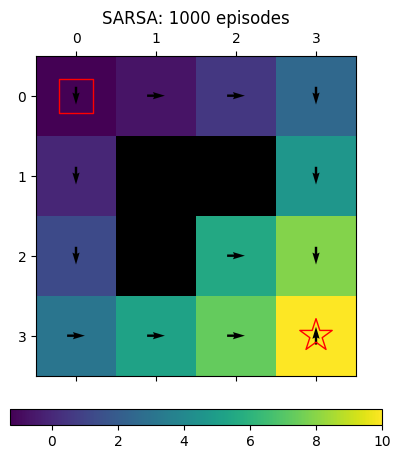

C:\Users\bened\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\bened\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


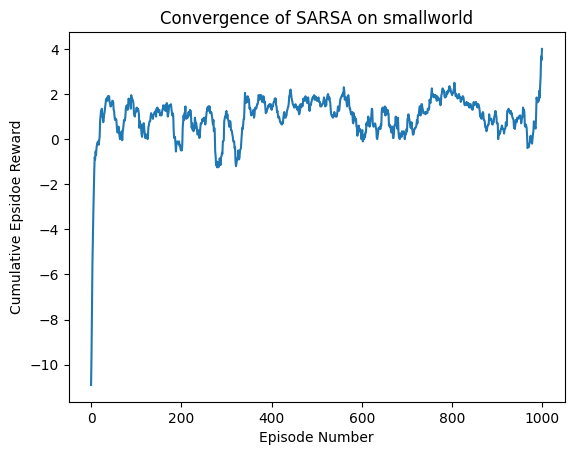

8.214 5


In [43]:
import matplotlib.pyplot as plt
from world_config import cliff_world, small_world, grid_world
from plot_vp import plot_vp
plt.style.use('default')

maxit = np.inf # 1000
num_episodes = 1000
alpha = 0.3
epsilon = 0.1
dynamic = False
world = {'cliffworld': cliff_world, 'gridworld': grid_world, 'smallworld': small_world}
choice = 'smallworld'
model = Model(world[choice])
pi, Q, V, episode_total_rewards, eps, iterations = SARSA(model, num_episodes, maxit, alpha=alpha, epsilon=epsilon, dynamic=dynamic)

plot_vp(model, V, pi, title=f'SARSA: {eps+1} episodes')
plt.savefig(f'Results/SARSA/alpha_{alpha}_epsilon_{epsilon}_'+str(choice)+'.png', bbox_inches='tight')
plt.show()

plt.plot(SMA(episode_total_rewards, size=20))
plt.xlabel('Episode Number')
plt.ylabel('Cumulative Epsidoe Reward')
plt.title(f'Convergence of SARSA on {choice}')

if not dynamic:
        plt.savefig(f'Results/SARSA/alpha_{alpha}_epsilon_{epsilon}_cumulative_reward_{choice}.png', bbox_inches='tight')
else:
    plt.savefig(f'Results/SARSA/alpha_{alpha}_dynamic_epsilon_cumulative_reward_{choice}.png', bbox_inches='tight')
plt.show()

print(np.mean(iterations), iterations[-1])

if choice == 'cliffworld':
    SARSA_rewards = episode_total_rewards

In [142]:
alphas_cumulative_rewards = []
for alpha in np.linspace(0.1, 1, 10):
    pi, Q, V, episode_total_rewards, eps = SARSA(model, num_episodes=200, maxit=100, alpha=0.5, epsilon=0.01, dynamic=True)
    alphas_cumulative_rewards.append(episode_total_rewards)

100%|██████████| 200/200 [00:01<00:00, 123.01it/s]


ValueError: too many values to unpack (expected 5)

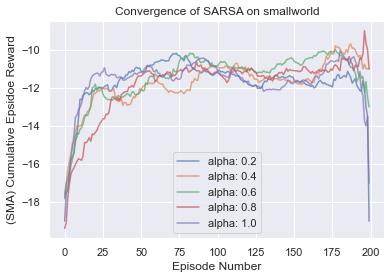

In [287]:
for i, alpha in enumerate(np.linspace(0.1, 1, 10)):
    if (i+1) % 2 == 0:
        windowed_cumulative_rewards = SMA(alphas_cumulative_rewards[i], size=50)
        plt.plot(windowed_cumulative_rewards, alpha=.7, label=f'alpha: {alpha:.1f}')

plt.xlabel('Episode Number')
plt.ylabel('(SMA) Cumulative Epsidoe Reward')
plt.title(f'Convergence of SARSA on {choice}')
# plt.ylim(-100, 0)
plt.legend()
plt.savefig(f'Results/SARSA/multi_alpha_dynamic_epsilon_cumulative_reward_{choice}.png', bbox_inches='tight')
plt.show()

100%|██████████| 200/200 [00:01<00:00, 108.32it/s]
C:\Users\bened\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\bened\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


3.6666666666666665


100%|██████████| 200/200 [00:02<00:00, 83.82it/s] 


1.46


100%|██████████| 200/200 [00:02<00:00, 88.48it/s] 


-4.36


100%|██████████| 200/200 [00:00<00:00, 206.10it/s]


4.0


100%|██████████| 200/200 [00:01<00:00, 120.88it/s]


4.0


100%|██████████| 200/200 [00:02<00:00, 73.93it/s]


-2.0


100%|██████████| 200/200 [00:03<00:00, 57.84it/s]


-11.285714285714286


100%|██████████| 200/200 [00:01<00:00, 156.08it/s]


1.16


100%|██████████| 200/200 [00:04<00:00, 43.62it/s]


-3.0


100%|██████████| 200/200 [00:04<00:00, 43.68it/s]


-17.78


100%|██████████| 200/200 [00:05<00:00, 35.36it/s]


-40.7


100%|██████████| 200/200 [00:04<00:00, 45.40it/s]


-9.66


100%|██████████| 200/200 [00:10<00:00, 19.80it/s]


-101.0


100%|██████████| 200/200 [00:09<00:00, 21.16it/s]


-101.0


100%|██████████| 200/200 [00:08<00:00, 23.23it/s]


-23.0


100%|██████████| 200/200 [00:09<00:00, 20.55it/s]


-101.0


100%|██████████| 200/200 [00:01<00:00, 138.94it/s]


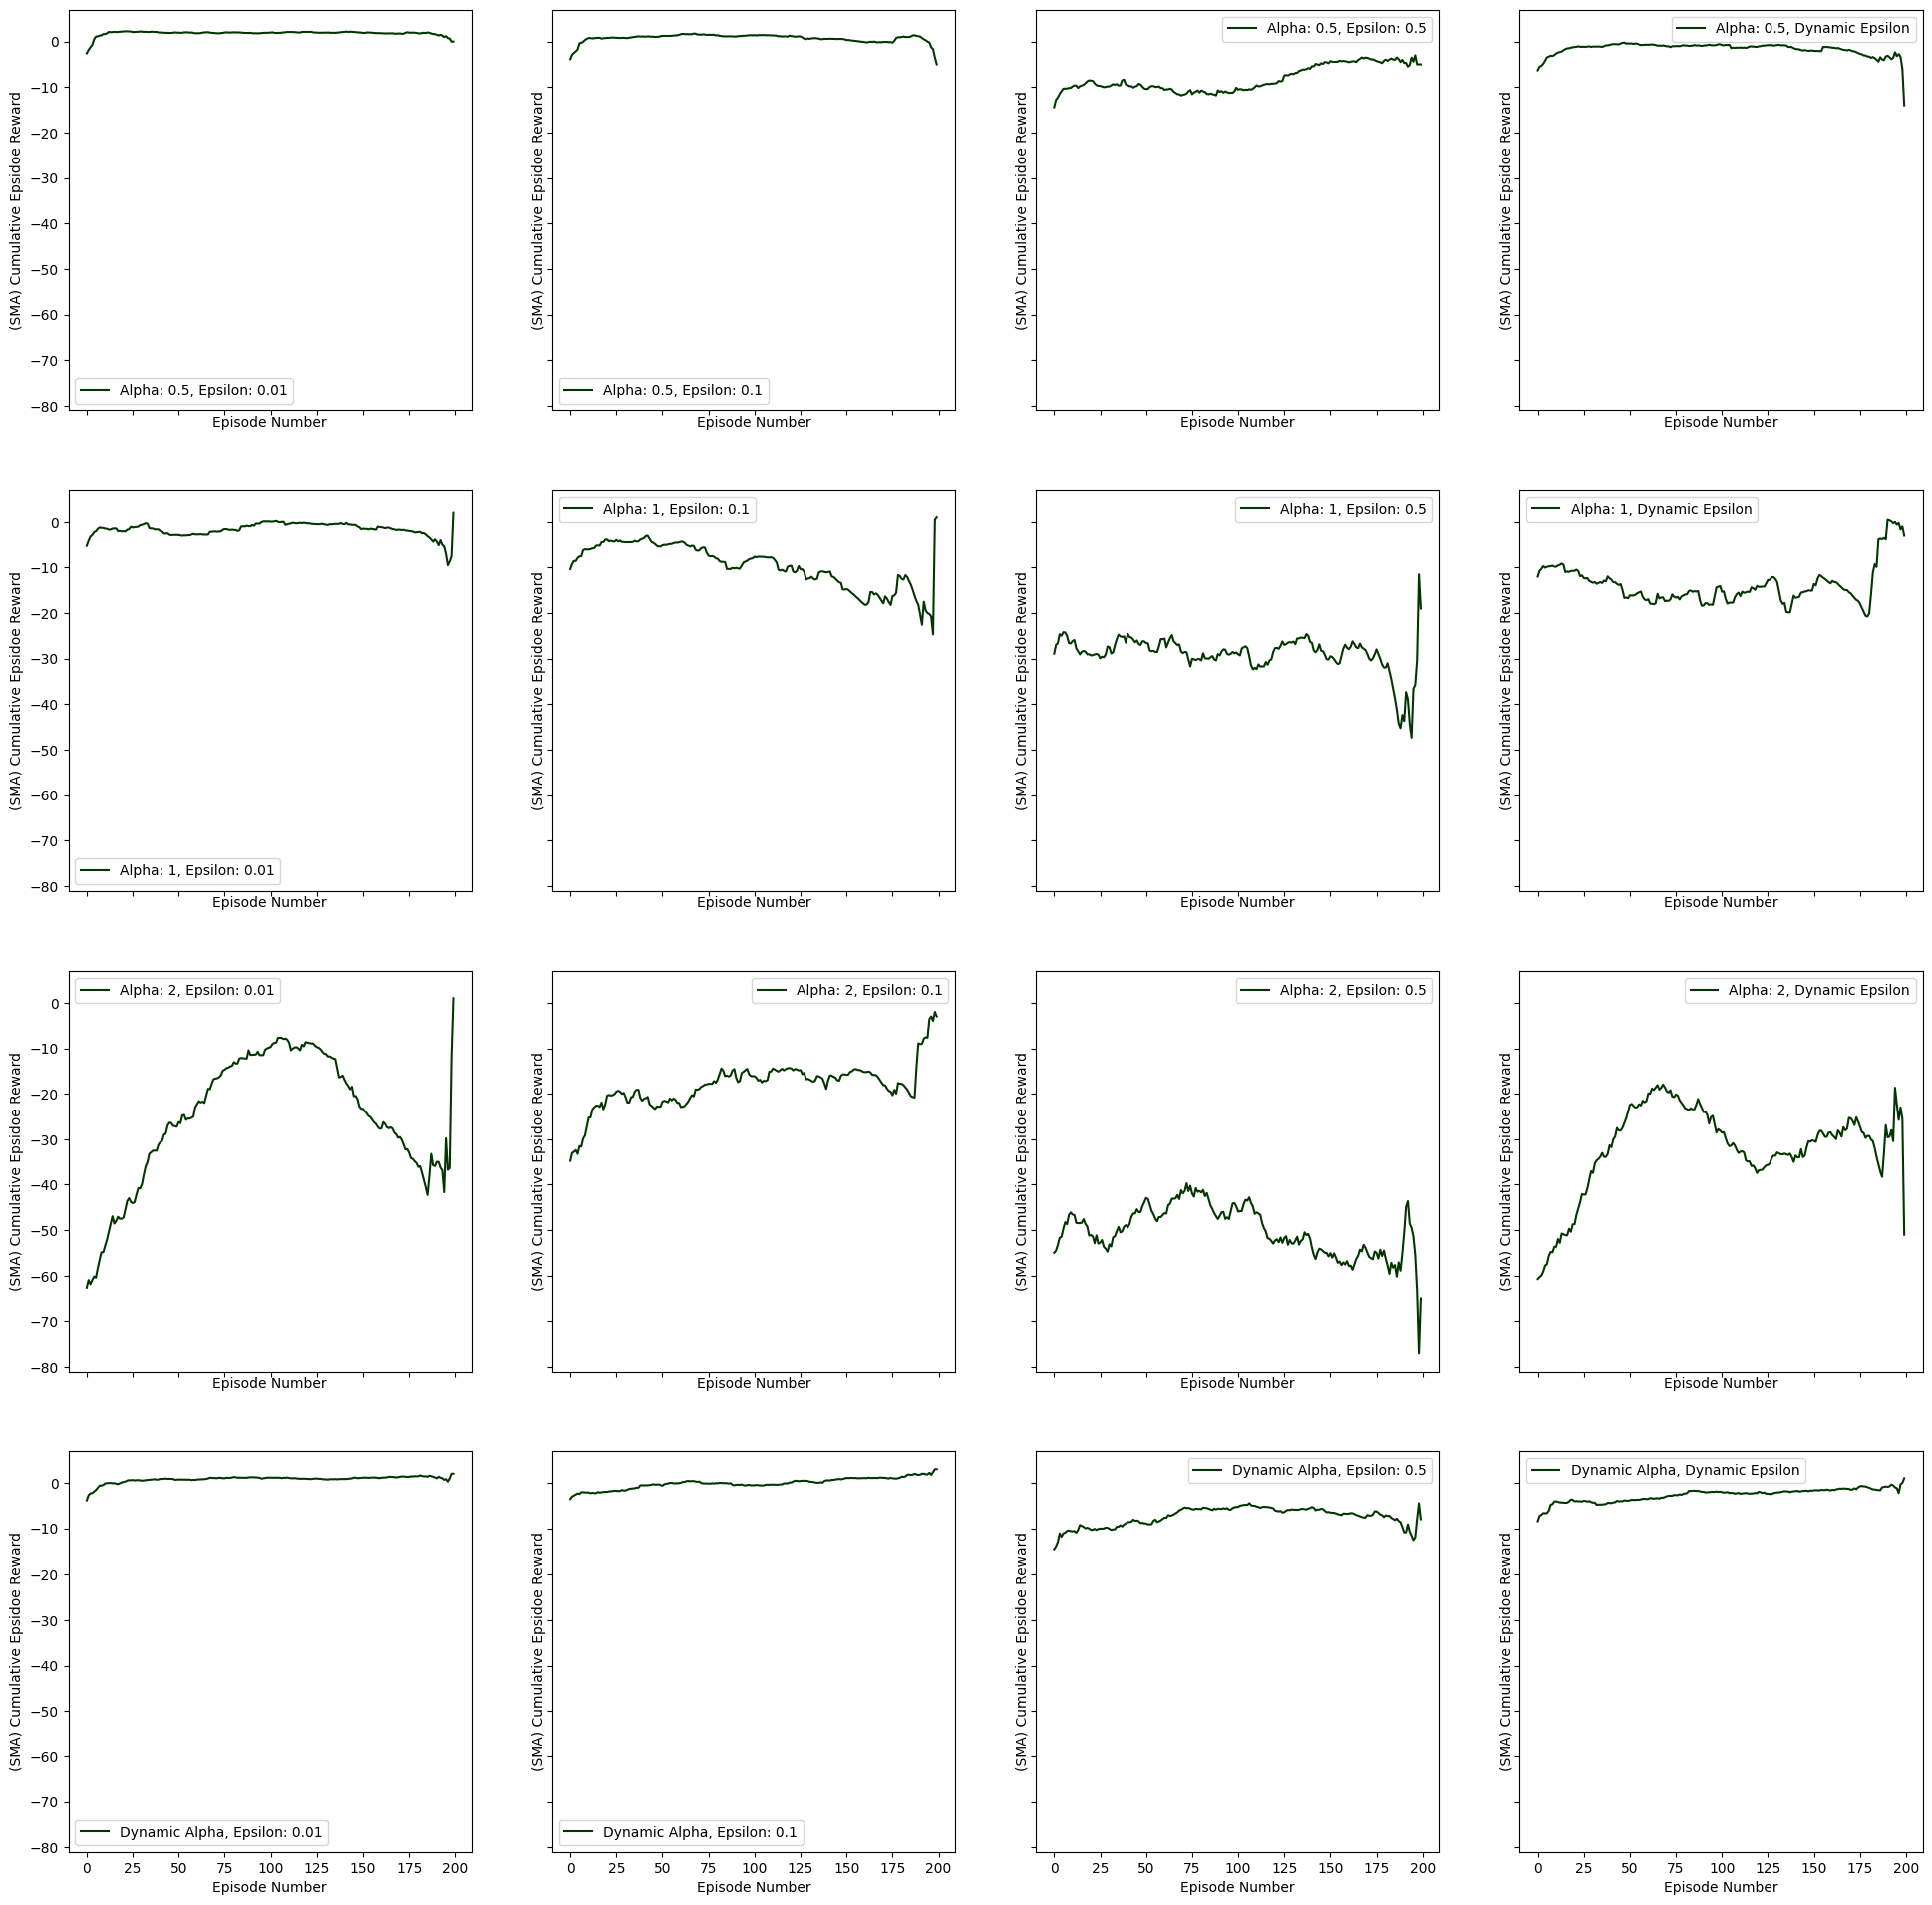

In [54]:
## Build a grid of plots for different alpha and epsilon values:

fig, axes = plt.subplots(nrows=4, ncols=4, sharex='all', sharey='all', figsize=(24, 24))

alphas = [0.5, 1, 2]
epsilons = [0.01, 0.1, 0.5]
for i, alpha in enumerate(alphas+[0]):
    for j, epsilon in enumerate(epsilons+[0]):
        pi, Q, V, episode_total_rewards, eps, _ = SARSA(model, num_episodes=200, maxit=100, alpha=alpha, epsilon=epsilon, dynamic=False)
        to_plot = SMA(episode_total_rewards, size=50)

        print(max(to_plot))

        if j < 3 and i < 3:
            pi, Q, V, episode_total_rewards, eps, _ = SARSA(model, num_episodes=200, maxit=100, alpha=alpha, epsilon=epsilon, dynamic=False)
            to_plot = SMA(episode_total_rewards, size=50)
            axes[i][j].plot(to_plot, 'xkcd:Dark Green', label=f'Alpha: {alpha}, Epsilon: {epsilon}', alpha=1)

        elif j == 3 and i < 3:
            pi, Q, V, episode_total_rewards, eps, _ = SARSA(model, num_episodes=200, maxit=100, alpha=alpha, epsilon=epsilon, dynamic=True)
            to_plot = SMA(episode_total_rewards, size=50)
            axes[i][j].plot(to_plot, 'xkcd:Dark Green', label=f'Alpha: {alpha}, Dynamic Epsilon', alpha=1)

        elif j < 3 and i == 3:
            pi, Q, V, episode_total_rewards, eps, _ = SARSA(model, num_episodes=200, maxit=100, alpha=alpha, epsilon=epsilon, dynamic=False, dynamic_alpha=True)
            to_plot = SMA(episode_total_rewards, size=50)
            axes[i][j].plot(to_plot, 'xkcd:Dark Green', label=f'Dynamic Alpha, Epsilon: {epsilon}', alpha=1)

        else:
            pi, Q, V, episode_total_rewards, eps, _ = SARSA(model, num_episodes=200, maxit=100, alpha=alpha, epsilon=epsilon, dynamic=True, dynamic_alpha=True)
            to_plot = SMA(episode_total_rewards, size=50)
            axes[i][j].plot(to_plot, 'xkcd:Dark Green', label=f'Dynamic Alpha, Dynamic Epsilon', alpha=1)
        
        axes[i][j].set_xlabel('Episode Number')
        axes[i][j].set_ylabel('(SMA) Cumulative Epsidoe Reward')
        axes[i][j].legend()

plt.savefig(f'Results/SARSA/grid_parameters_cumulative_reward_{choice}.png', bbox_inches='tight')
plt.show()

### Expected SARSA:

In [56]:
def ExpectedSARSA(model: Model, num_episodes: int = 100, maxit: int = 1000, alpha=0.1, epsilon=0.01, dynamic=False, dynamic_alpha=False):
    
    ## Initialise Q-func values and policy:
    Q = np.zeros((len(model.states), len(Actions)))
    V = np.zeros((len(model.states,)))
    pi = [Actions(0)] * len(model.states) # intialise policy actions from all states to 0 arbitrarily
    
    def choose_action(s: int, epsilon):
        if np.random.uniform(0,1) < epsilon:
            return np.random.randint(Q.shape[1])
        else:
            return np.argmax(Q[s])

    def update_Q(s, a, r, s_next, alpha, epsilon):
        # Expected SARSA doesn't need the new action as it takes the expected q-function value over all actions given next state.
        # However, the next action is defined below for purposes of moving the exploration of the agent forward.

        expQ = 0
        maxQ = np.max(Q[s_next, :])
        chose_greedy = 0
        for i in range(len(Actions)):
            if Q[s_next][i] == maxQ:
                chose_greedy += 1
        prob_non_greedy = epsilon / len(Actions)
        prob_greedy = ((1 - epsilon) / chose_greedy) + prob_non_greedy
        for i in range(len(Actions)):
            if Q[s_next][i] == maxQ:
                expQ += Q[s_next][i] * prob_greedy
            else:
                expQ += Q[s_next][i] * prob_non_greedy

        Q[s][a] += alpha * (r + model.gamma*expQ - Q[s][a])

    def update_pi(s):
        optimal_action_index = np.argmax(Q[s, :])
        pi[s] = Actions(optimal_action_index)

    # def record_V(s, a): #!! TODO: Correct way of computing value function?
        # V[s] = np.sum([model.transition_probability(s, s_, a) * (model.reward(s, a) + model.gamma * V[s_]) for s_ in model.states])

    episode_total_rewards = []
    threshold = 0.0001
    iterations = []

    for i in trange(num_episodes):

        pi_old = pi.copy()
        Q_old = Q.copy()
        episode_over = False
        cumulative_reward = 0
        s = model.start_state
        if not dynamic:
            eps = epsilon 
        else:
            eps = 1 / (i+1)
        if dynamic_alpha:
            alpha = 1 / (i+1)

        action = choose_action(s, eps)
        j = 1
        
        while not episode_over and j <= maxit:
            immediate_reward = model.reward(s, action)
            cumulative_reward += immediate_reward

            # Move to next state by sampling s_next from P_Transition(s_next, s, a)
            s_next = np.random.choice(model.states[:-1], p=[model.transition_probability(s, s_, action) for s_ in model.states[:-1]])
            a_next = choose_action(s_next, epsilon=eps)

            update_Q(s, action, immediate_reward, s_next, alpha, epsilon)
            update_pi(s)
            # record_V(s, action)

            s = s_next
            action = a_next
            if s == model.goal_state:
                episode_over = True
                iterations.append(j)
                Q[s][action] += alpha*(model.reward(s, action) - Q[s][action])
                cumulative_reward += model.reward(s, action)

            j += 1

        # if s != model.goal_state:
            # print(f'Episode {i+1} broke early due to exceeding iteration allowance.')

        # if pi_old == pi and max(abs(Q_old - Q).flatten()) < threshold:
        #     print('Breaking loop over episodes as policy has converged.')
        #     break

        episode_total_rewards.append(cumulative_reward)
        for s in model.states:
                    V[s] = np.max([Q[s][a] for a in Actions])
    return pi, Q, V, episode_total_rewards, i, iterations

100%|██████████| 1000/1000 [00:06<00:00, 164.55it/s]


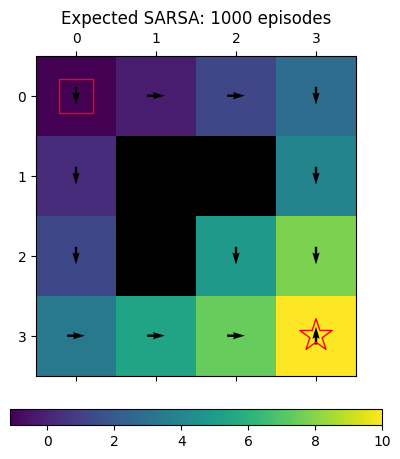

C:\Users\bened\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\bened\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


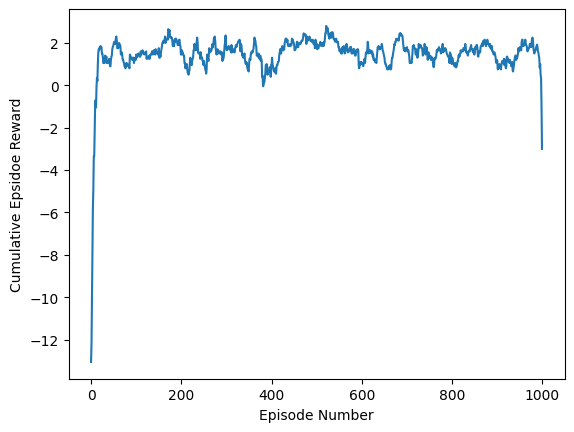

8.718 13


In [46]:
import matplotlib.pyplot as plt
from world_config import cliff_world, small_world, grid_world
from plot_vp import plot_vp
plt.style.use('default')

maxit = np.inf
num_episodes = 1000
world = {'cliffworld': cliff_world, 'gridworld': grid_world, 'smallworld': small_world}
choice = 'smallworld'
model = Model(world[choice])
dynamic, alpha, epsilon = False, 0.3, 0.1
pi, Q, V, episode_total_rewards, eps, iterations = ExpectedSARSA(model, num_episodes, maxit, dynamic=dynamic, alpha=alpha, epsilon=epsilon)
plot_vp(model, V, pi, title=f'Expected SARSA: {eps+1} episodes')
plt.savefig(f'Results/Expected SARSA/alpha_{alpha}_epsilon_{epsilon}_'+str(choice)+'.png', bbox_inches='tight')
plt.show()

plt.plot(SMA(episode_total_rewards, size=20))
plt.xlabel('Episode Number')
plt.ylabel('Cumulative Epsidoe Reward')
# plt.title(f'Convergence of Expected SARSA on {choice}')
# plt.ylim(-100, 0)
plt.savefig(f'Results/Expected SARSA/alpha_{alpha}_epsilon_{epsilon}_cumulative_reward_{choice}.png', bbox_inches='tight')
plt.show()

print(np.mean(iterations), iterations[-1])

if choice == 'cliffworld':
    Exp_SARSA_rewards = episode_total_rewards

In [317]:
ESARSA_cumReturns_alphas = []
for alpha in [0.1, 0.2, 0.5, 1, 1.5, 2]:
    pi, Q, V, episode_total_rewards, eps = ExpectedSARSA(model, num_episodes=100, maxit=100, alpha=0.5, epsilon=0.01, dynamic=dynamic)
    ESARSA_cumReturns_alphas.append(episode_total_rewards)
    

100%|██████████| 100/100 [00:01<00:00, 70.72it/s]


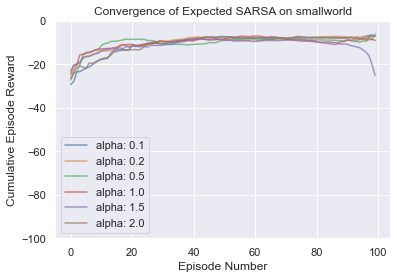

In [318]:
for i, alpha in enumerate([0.1, 0.2, 0.5, 1, 1.5, 2]):
    plt.plot(SMA(ESARSA_cumReturns_alphas[i], size=20), alpha=.7, label=f'alpha: {alpha:.1f}')

plt.xlabel('Episode Number')
plt.ylabel('Cumulative Episode Reward')
plt.title(f'Convergence of Expected SARSA on {choice}')
plt.ylim(-100, 0)
plt.savefig(f'Results/Expected SARSA/varying_alpha_epsilon_{epsilon}_{choice}.png', bbox_inches='tight')
plt.legend()
plt.show()

100%|██████████| 200/200 [00:03<00:00, 62.56it/s]


3.6666666666666665


100%|██████████| 200/200 [00:03<00:00, 61.14it/s]


1.88


100%|██████████| 200/200 [00:04<00:00, 44.30it/s]


-2.82


100%|██████████| 200/200 [00:03<00:00, 64.15it/s]


4.0


100%|██████████| 200/200 [00:03<00:00, 60.50it/s]


3.0


100%|██████████| 200/200 [00:04<00:00, 49.66it/s]


2.0


100%|██████████| 200/200 [00:05<00:00, 36.90it/s]


-1.6666666666666667


100%|██████████| 200/200 [00:03<00:00, 60.38it/s]


4.0


100%|██████████| 200/200 [00:15<00:00, 12.79it/s]


-15.44


100%|██████████| 200/200 [00:14<00:00, 13.45it/s]


3.0


100%|██████████| 200/200 [00:18<00:00, 11.06it/s]


-33.0


100%|██████████| 200/200 [00:13<00:00, 14.80it/s]


-9.0


100%|██████████| 200/200 [00:28<00:00,  7.04it/s]


-100.0


100%|██████████| 200/200 [00:27<00:00,  7.20it/s]


-100.0


100%|██████████| 200/200 [00:23<00:00,  8.46it/s]


-88.5


100%|██████████| 200/200 [00:28<00:00,  7.00it/s]


-100.0


100%|██████████| 200/200 [00:03<00:00, 61.33it/s]


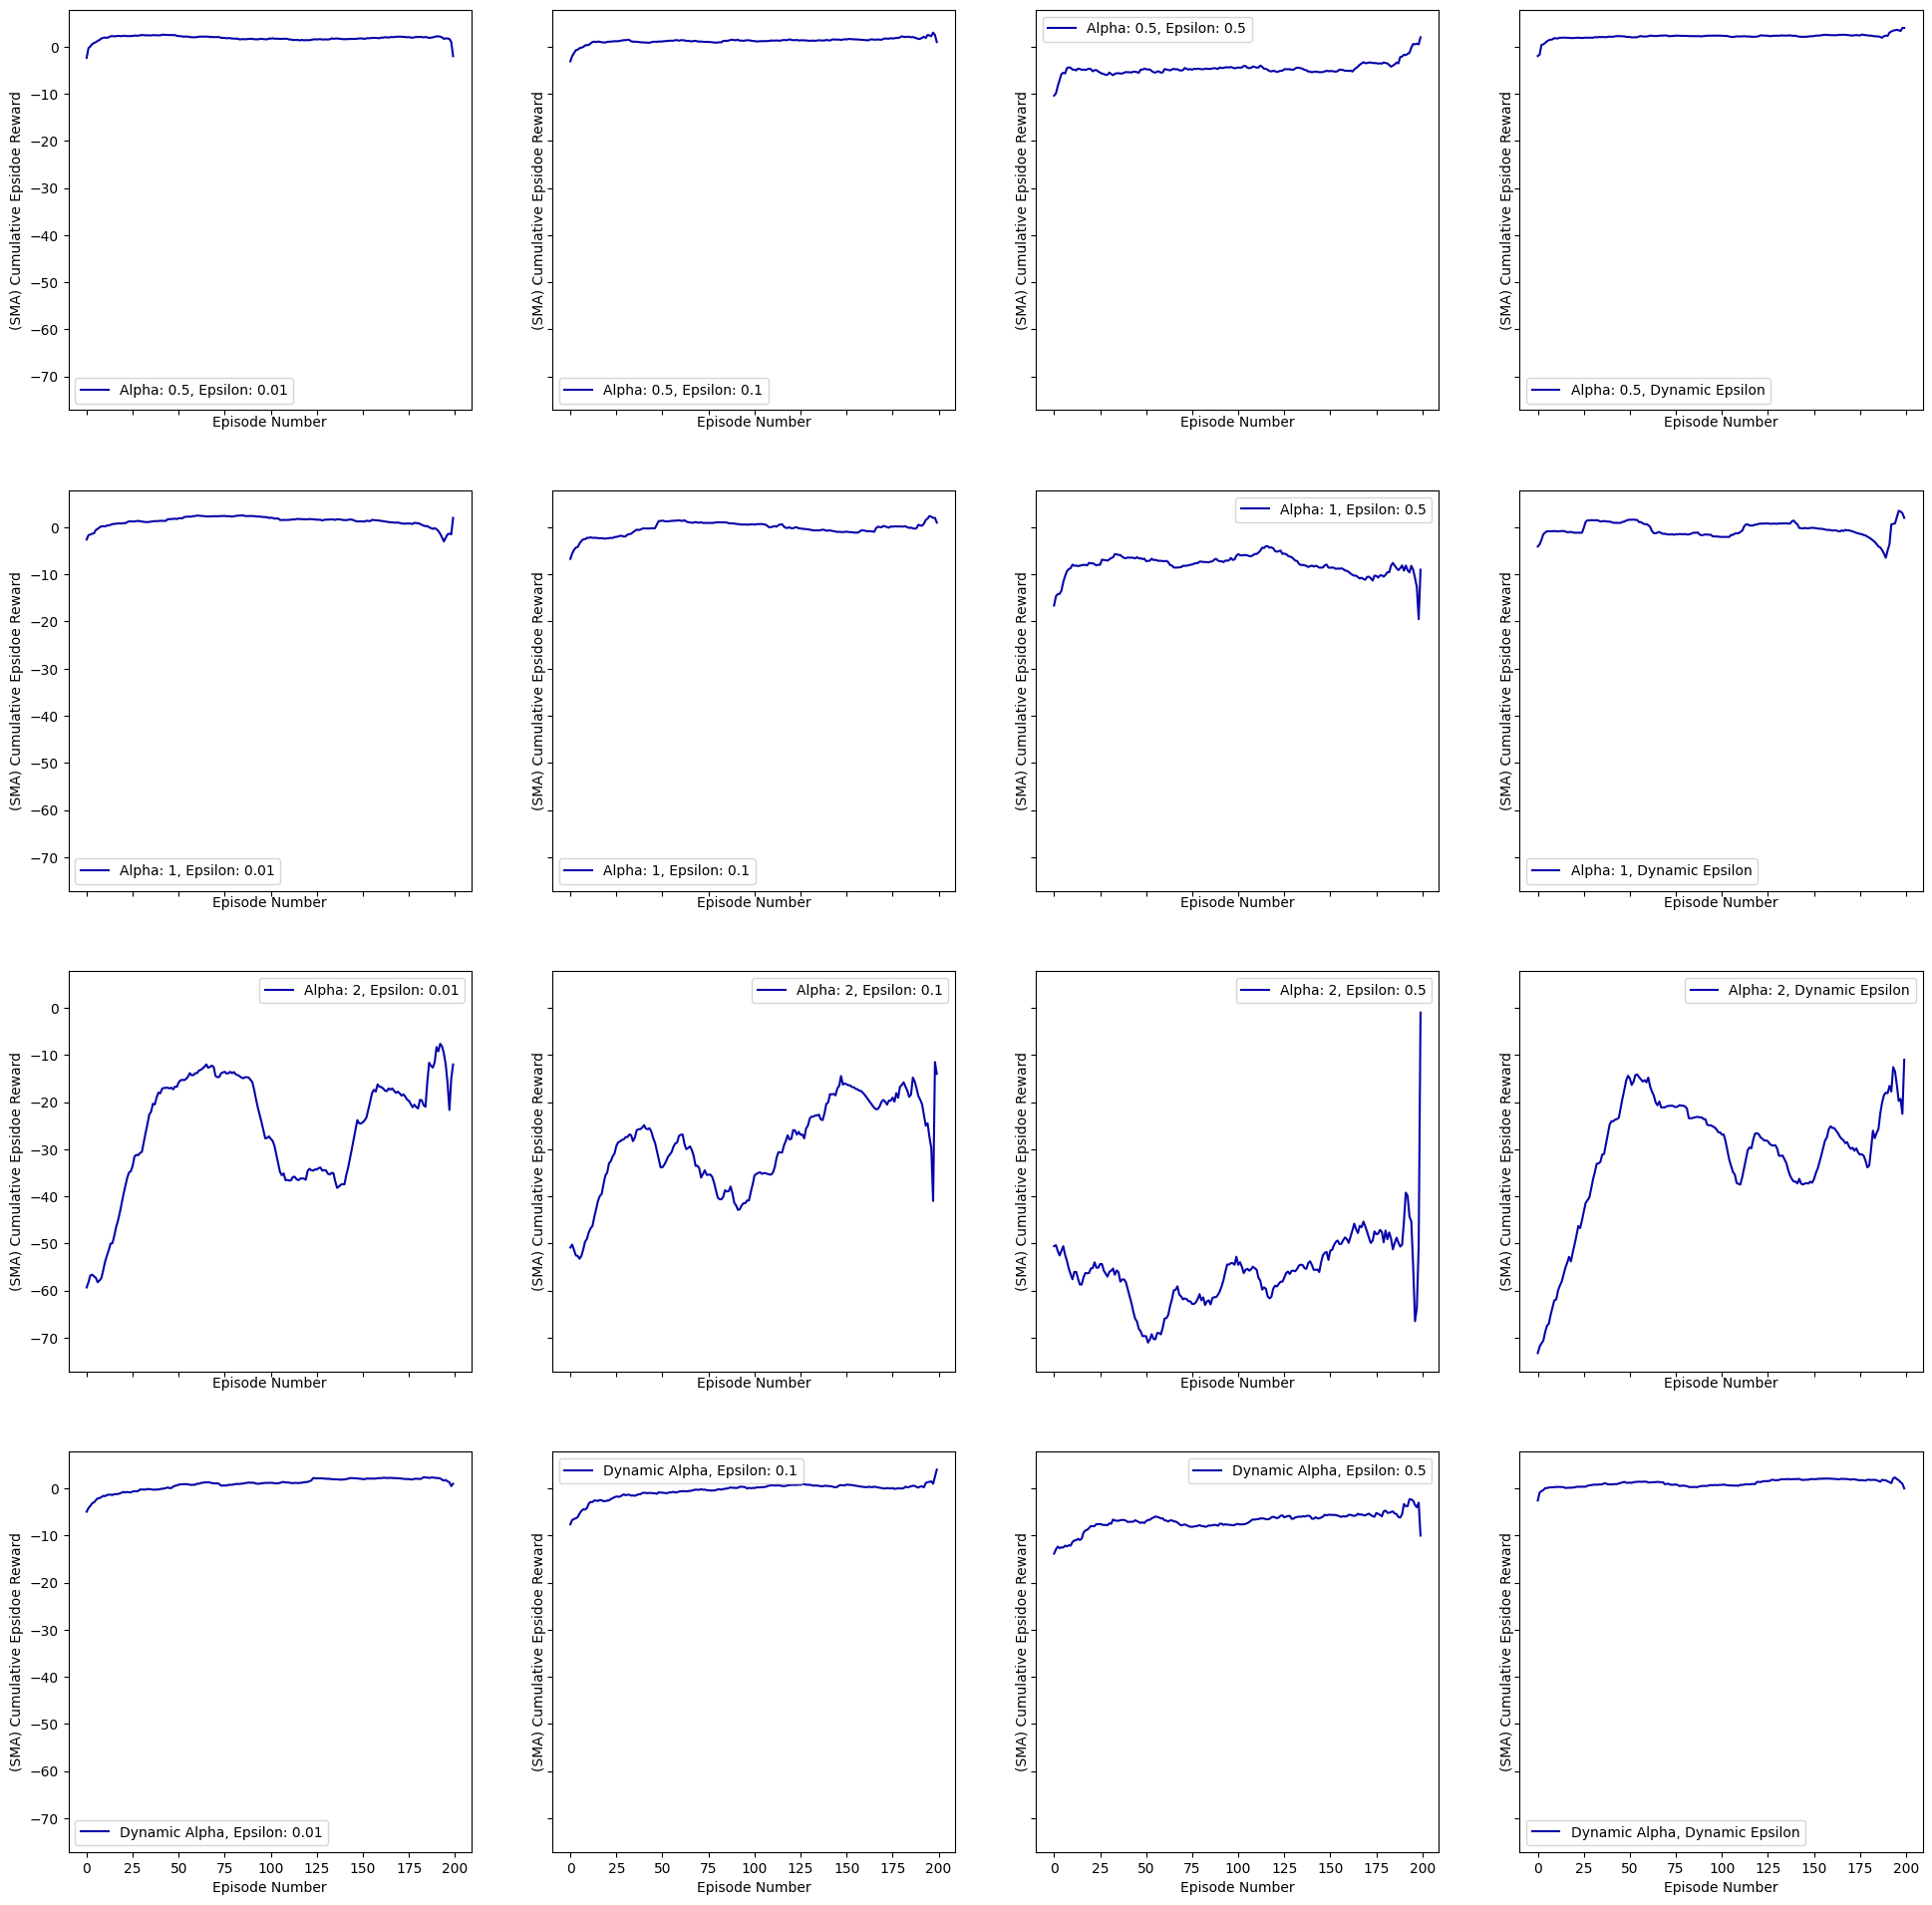

In [61]:
## Build a grid of plots for different alpha and epsilon values:

fig, axes = plt.subplots(nrows=4, ncols=4, sharex='all', sharey='all', figsize=(24, 24))

alphas = [0.5, 1, 2]
epsilons = [0.01, 0.1, 0.5]
for i, alpha in enumerate(alphas+[0]):
    for j, epsilon in enumerate(epsilons+[0]):
        pi, Q, V, episode_total_rewards, eps, _ = ExpectedSARSA(model, num_episodes=200, maxit=100, alpha=alpha, epsilon=epsilon, dynamic=False)
        to_plot = SMA(episode_total_rewards, size=50)

        print(max(to_plot))

        if j < 3 and i < 3:
            pi, Q, V, episode_total_rewards, eps, _ = ExpectedSARSA(model, num_episodes=200, maxit=100, alpha=alpha, epsilon=epsilon, dynamic=False)
            to_plot = SMA(episode_total_rewards, size=50)
            axes[i][j].plot(to_plot, 'xkcd:Royal Blue', label=f'Alpha: {alpha}, Epsilon: {epsilon}', alpha=1)

        elif j == 3 and i < 3:
            pi, Q, V, episode_total_rewards, eps, _ = ExpectedSARSA(model, num_episodes=200, maxit=100, alpha=alpha, epsilon=epsilon, dynamic=True)
            to_plot = SMA(episode_total_rewards, size=50)
            axes[i][j].plot(to_plot, 'xkcd:Royal Blue', label=f'Alpha: {alpha}, Dynamic Epsilon', alpha=1)

        elif j < 3 and i == 3:
            pi, Q, V, episode_total_rewards, eps, _ = ExpectedSARSA(model, num_episodes=200, maxit=100, alpha=alpha, epsilon=epsilon, dynamic=False, dynamic_alpha=True)
            to_plot = SMA(episode_total_rewards, size=50)
            axes[i][j].plot(to_plot, 'xkcd:Royal Blue', label=f'Dynamic Alpha, Epsilon: {epsilon}', alpha=1)

        else:
            pi, Q, V, episode_total_rewards, eps, _ = ExpectedSARSA(model, num_episodes=200, maxit=100, alpha=alpha, epsilon=epsilon, dynamic=True, dynamic_alpha=True)
            to_plot = SMA(episode_total_rewards, size=50)
            axes[i][j].plot(to_plot, 'xkcd:Royal Blue', label=f'Dynamic Alpha, Dynamic Epsilon', alpha=1)
        
        axes[i][j].set_xlabel('Episode Number')
        axes[i][j].set_ylabel('(SMA) Cumulative Epsidoe Reward')
        axes[i][j].legend()

plt.savefig(f'Results/Expected SARSA/grid_parameters_cumulative_reward_{choice}.png', bbox_inches='tight')
plt.show()

## Part C: Q-Learning:

In [13]:
from cgitb import small
from typing import Callable
from matplotlib.pyplot import grid
from tqdm import tqdm, trange
import numpy as np
from model import Model, Actions

In [58]:
def QLearning(model: Model, num_episodes: int = 100, maxit: int = 1000, alpha: int = 1, epsilon: int = 0.01, dynamic: bool = False, dynamic_alpha: bool = False):
    
    ## Initialise Q-func values and policy:
    Q = np.zeros((len(model.states), len(Actions)))
    V = np.zeros((len(model.states,)))
    pi = [Actions(0)] * len(model.states) # intialise policy actions from all states to 0 arbitrarily
    
    def choose_action(s: int, epsilon):
        if np.random.uniform(0,1) < epsilon:
            return np.random.randint(Q.shape[1])
        else:
            return np.argmax(Q[s])

    def update_Q(s, a, r, s_next, alpha):
        # Q-Learning always takes the greedy approach for a_next when judging current state value, 
        # and this doesn't need the a_next chosen below in the loop:
        Q[s][a] += alpha * (r + model.gamma*max(Q[s_next, :]) - Q[s][a])

    def update_pi(s):
        optimal_action_index = np.argmax([Q[s][a.value] for a in Actions])
        pi[s] = Actions(optimal_action_index)

    # def record_V(s, a): #!! TODO: Correct way of computing value function?
    #     V[s] = np.sum([model.transition_probability(s, s_, a) * (model.reward(s, a) + model.gamma * V[s_]) for s_ in model.states])

    episode_total_rewards = []
    threshold = 0.0001
    iterations = []
    
    for i in trange(num_episodes):

        pi_old = pi.copy()
        Q_old = Q.copy()
        episode_over = False
        cumulative_reward = 0
        s = model.start_state
        action = 1 # choose_action(s, epsilon=0) # arbitrarily take a greedy action
        j = 0

        while not episode_over and j <= maxit:
            if dynamic:
                eps = 1 / (j+1)
            else:
                eps = epsilon
            if dynamic_alpha:
                alpha = 1 / (i+1)

            immediate_reward = model.reward(s, action)
            cumulative_reward += immediate_reward

            # Move to next state by sampling s_next from P_Transition(s_next, s, a)
            s_next = np.random.choice(model.states[:-1], p=[model.transition_probability(s, s_, action) for s_ in model.states[:-1]])
            a_next = choose_action(s_next, epsilon=eps)

            update_Q(s, action, immediate_reward, s_next, alpha)
            update_pi(s)
            # record_V(s, action)

            s = s_next
            action = a_next
            if s == model.goal_state:
                episode_over = True
                iterations.append(j)
                Q[s][action] += alpha*(model.reward(s, action) - Q[s][action])
                cumulative_reward += model.reward(s, action)    

            j += 1

        # if s != model.goal_state:
            # print(f'Episode {i+1} broke early due to exceeding iteration allowance.')
        # if max(abs(Q_old - Q).flatten()) < threshold:
        #     break

        episode_total_rewards.append(cumulative_reward)
        for s in model.states:
                    V[s] = np.max([Q[s][a] for a in Actions])
    
    return pi, Q, V, episode_total_rewards, i, iterations

100%|██████████| 1000/1000 [00:05<00:00, 174.19it/s]


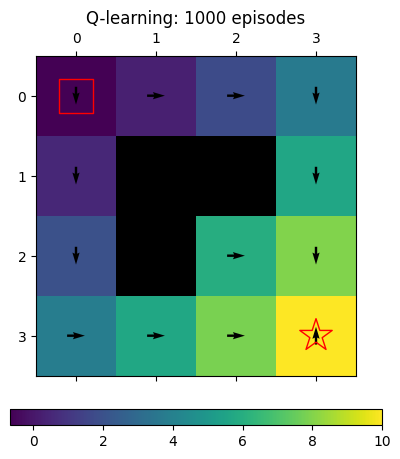

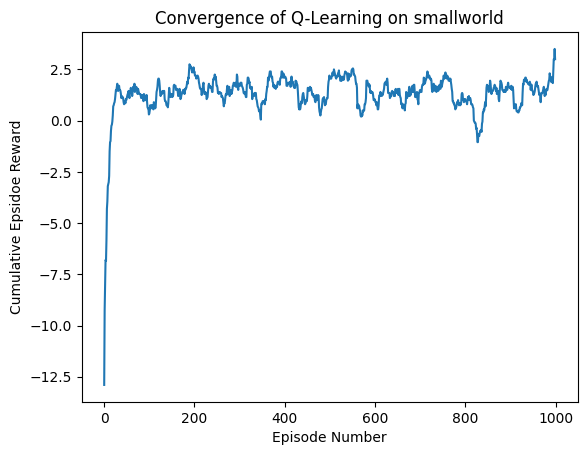

7.89 6


In [49]:
import matplotlib.pyplot as plt
from world_config import cliff_world, small_world, grid_world
from plot_vp import plot_vp

maxit = np.inf
num_episodes = 1000
world = {'cliffworld': cliff_world, 'gridworld': grid_world, 'smallworld': small_world}
choice = 'smallworld'
model = Model(world[choice])
dynamic, alpha, epsilon = False, 0.3, 0.1
pi, Q, V, episode_total_rewards, eps, its = QLearning(model, num_episodes, maxit, alpha, epsilon, dynamic)
if eps+1 == num_episodes:
    plot_vp(model, V, pi, title=f'Q-learning: {eps+1} episodes')
else:
    plot_vp(model, V, pi, title=None)
# plt.savefig('Results/Q-Learning/str(choice)+'.png', bbox_inches='tight')
plt.show()

plt.plot(SMA(episode_total_rewards, size=20))
plt.xlabel('Episode Number')
plt.ylabel('Cumulative Epsidoe Reward')
plt.title(f'Convergence of Q-Learning on {choice}')
# plt.ylim(-100, 0)
plt.savefig(f'Results/Q-Learning/cumulative_reward_{choice}.png', bbox_inches='tight')
plt.show()

print(np.mean(its), its[-1])

if choice == 'cliffworld':
    QLearning_rewards = episode_total_rewards

100%|██████████| 200/200 [00:00<00:00, 210.57it/s]


2.761904761904762


100%|██████████| 200/200 [00:01<00:00, 197.88it/s]


3.0


100%|██████████| 200/200 [00:01<00:00, 136.22it/s]


-2.0


100%|██████████| 200/200 [00:00<00:00, 215.22it/s]


2.8


100%|██████████| 200/200 [00:01<00:00, 177.51it/s]


4.0


100%|██████████| 200/200 [00:01<00:00, 134.62it/s]


-0.48


100%|██████████| 200/200 [00:01<00:00, 101.23it/s]


0.0


100%|██████████| 200/200 [00:01<00:00, 172.36it/s]


4.0


100%|██████████| 200/200 [00:04<00:00, 49.59it/s]


-11.72


100%|██████████| 200/200 [00:06<00:00, 29.96it/s]


-39.88


 81%|████████  | 162/200 [00:05<00:01, 24.77it/s]<ipython-input-58-faf8e9c4a4b7>:17: RuntimeWarning: overflow encountered in double_scalars
  Q[s][a] += alpha * (r + model.gamma*max(Q[s_next, :]) - Q[s][a])
<ipython-input-58-faf8e9c4a4b7>:17: RuntimeWarning: invalid value encountered in double_scalars
  Q[s][a] += alpha * (r + model.gamma*max(Q[s_next, :]) - Q[s][a])
100%|██████████| 200/200 [00:06<00:00, 30.95it/s]


-58.16


100%|██████████| 200/200 [00:09<00:00, 20.21it/s]


-100.18


100%|██████████| 200/200 [00:09<00:00, 21.39it/s]


-101.0


100%|██████████| 200/200 [00:09<00:00, 22.10it/s]


-101.0


100%|██████████| 200/200 [00:08<00:00, 24.96it/s]


-92.42857142857143


100%|██████████| 200/200 [00:09<00:00, 21.53it/s]


-101.0


100%|██████████| 200/200 [00:01<00:00, 170.41it/s]


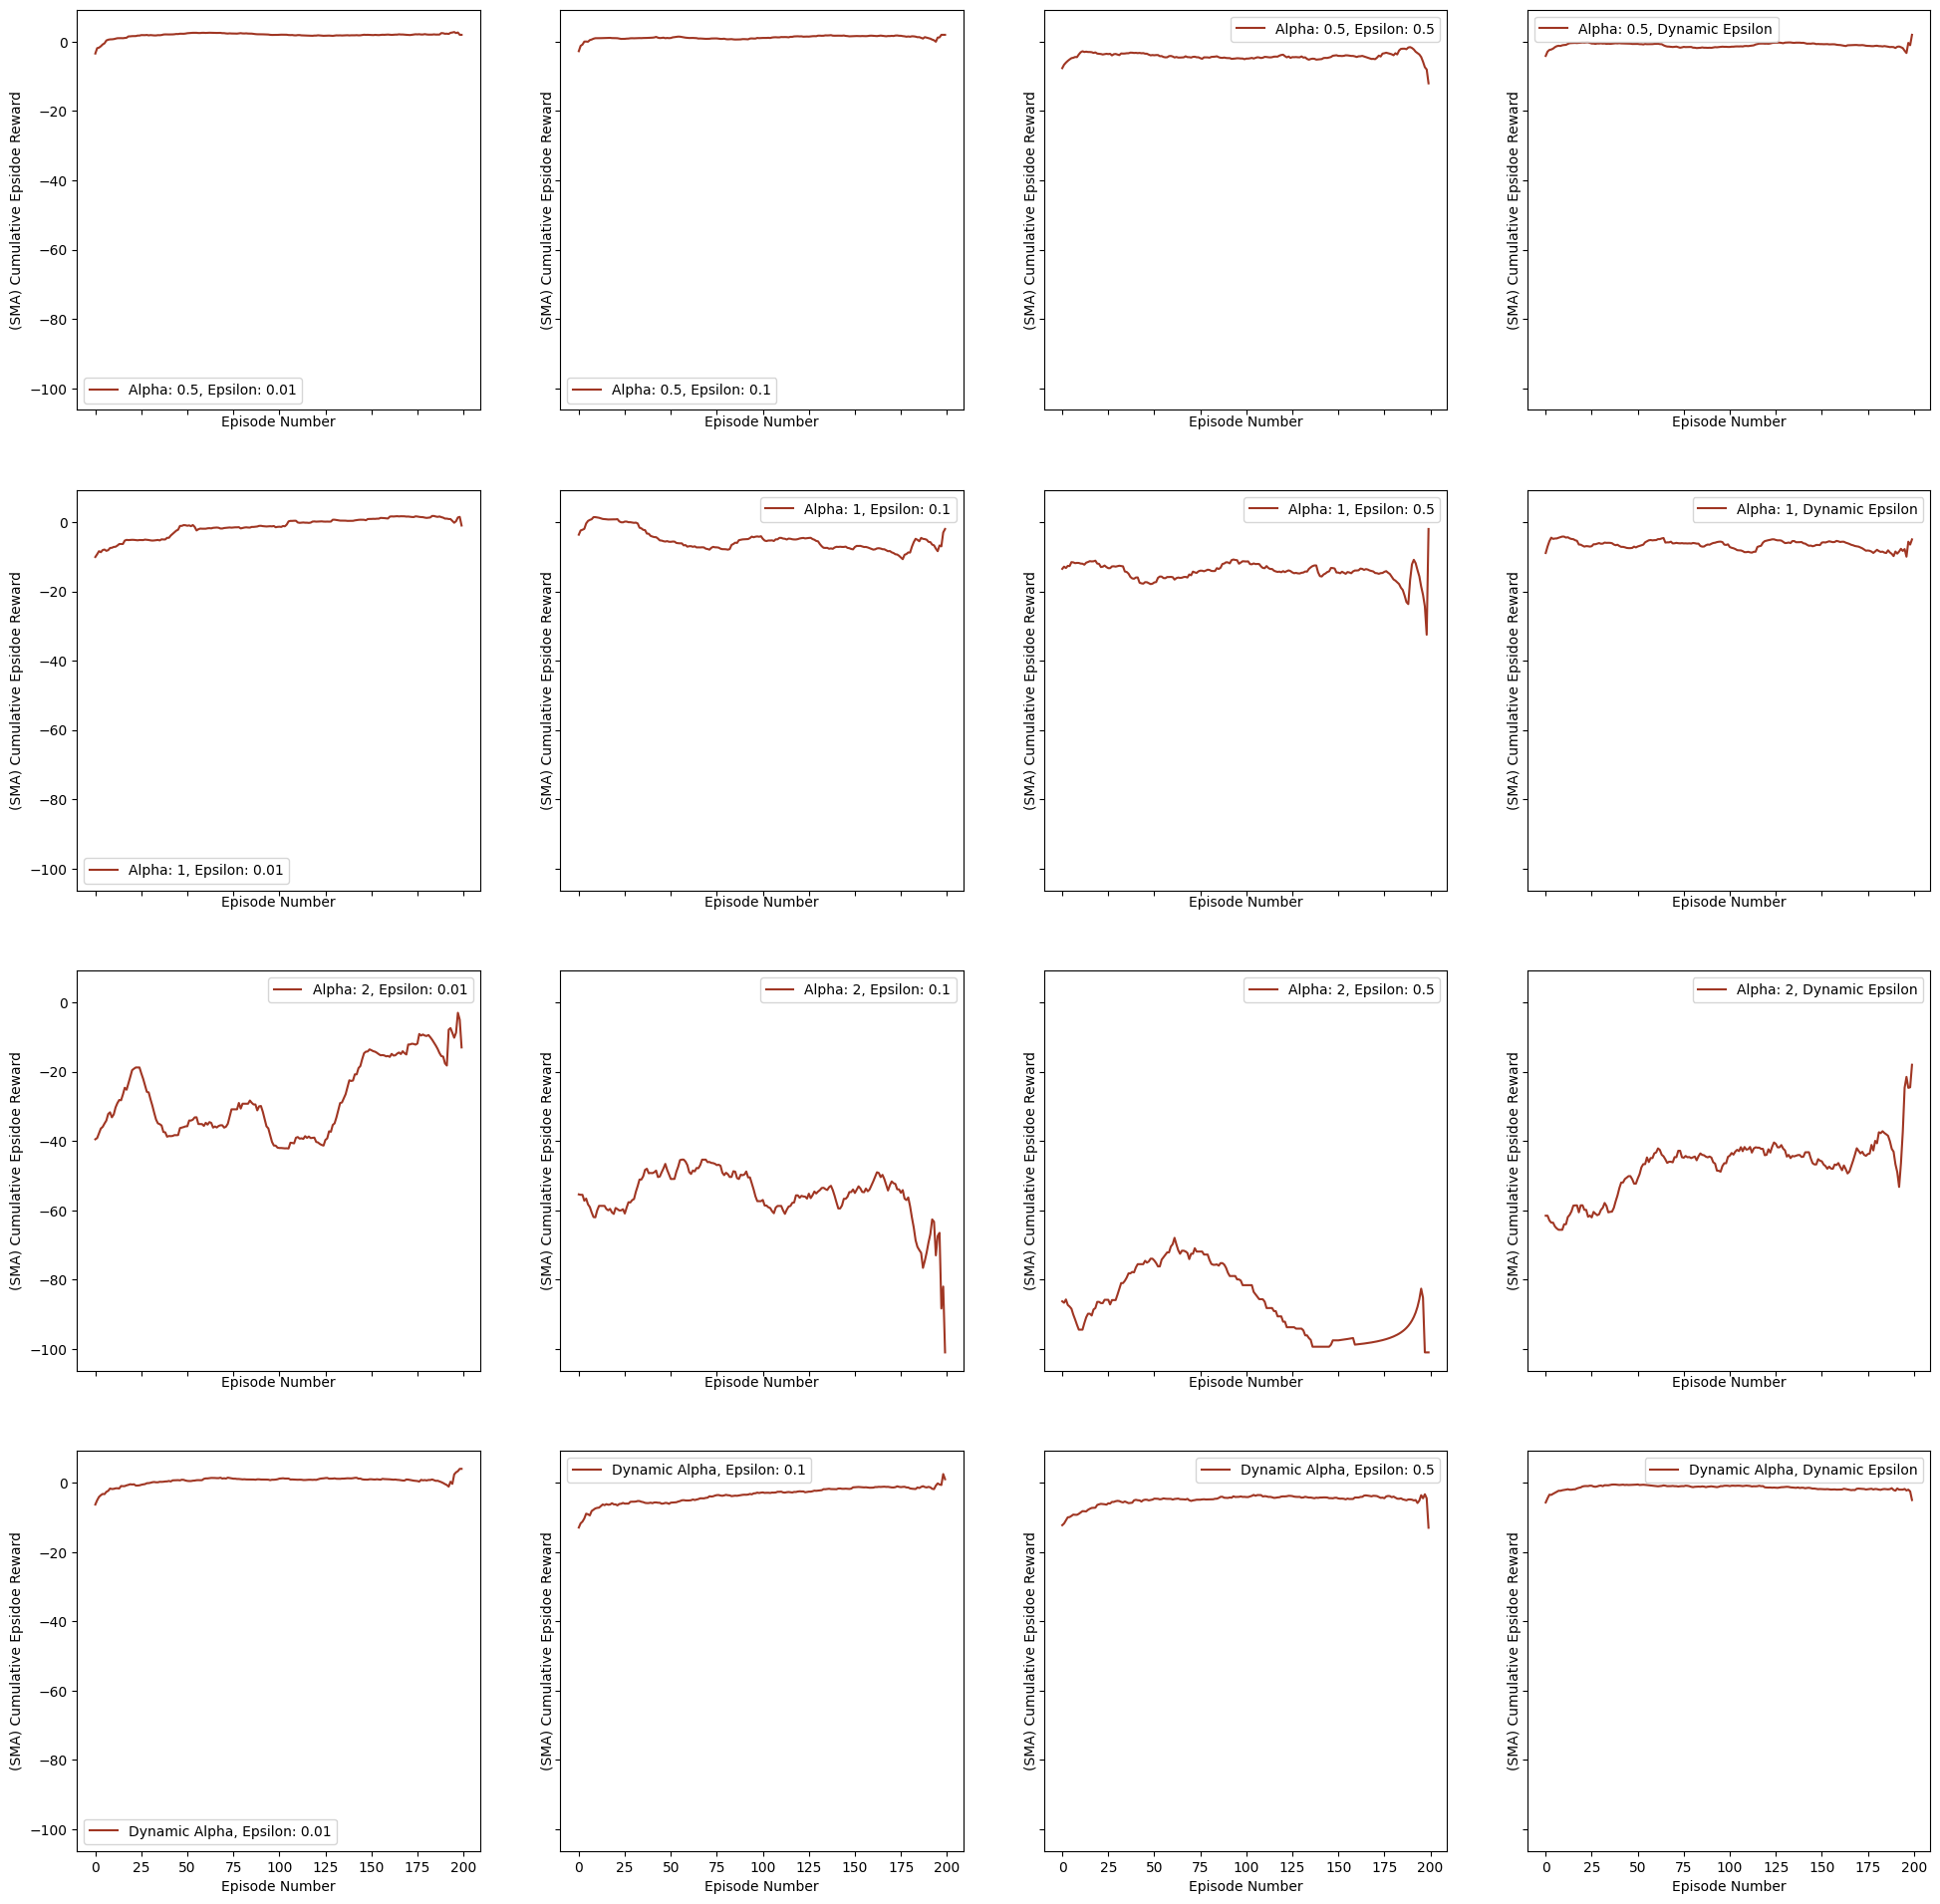

100%|██████████| 200/200 [00:09<00:00, 21.64it/s]


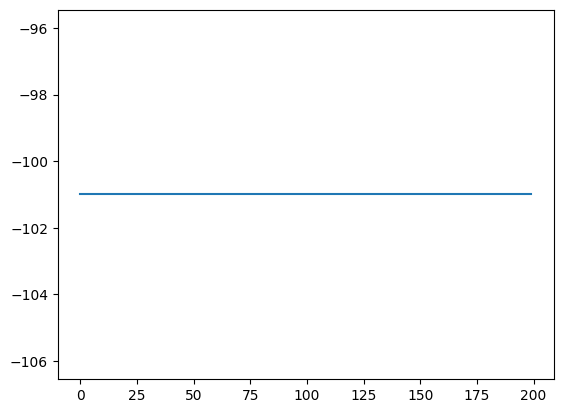

In [59]:
## Build a grid of plots for different alpha and epsilon values:

fig, axes = plt.subplots(nrows=4, ncols=4, sharex='all', sharey='all', figsize=(24, 24))

alphas = [0.5, 1, 2]
epsilons = [0.01, 0.1, 0.5]
for i, alpha in enumerate(alphas+[0]):
    for j, epsilon in enumerate(epsilons+[0]):
        pi, Q, V, episode_total_rewards, eps, _ = QLearning(model, num_episodes=200, maxit=100, alpha=alpha, epsilon=epsilon, dynamic=False)
        to_plot = SMA(episode_total_rewards, size=50)

        print(max(to_plot))

        if j < 3 and i < 3:
            pi, Q, V, episode_total_rewards, eps, _ = QLearning(model, num_episodes=200, maxit=100, alpha=alpha, epsilon=epsilon, dynamic=False)
            to_plot = SMA(episode_total_rewards, size=50)
            axes[i][j].plot(to_plot, 'xkcd:Brick', label=f'Alpha: {alpha}, Epsilon: {epsilon}', alpha=1)

        elif j == 3 and i < 3:
            pi, Q, V, episode_total_rewards, eps, _ = QLearning(model, num_episodes=200, maxit=100, alpha=alpha, epsilon=epsilon, dynamic=True)
            to_plot = SMA(episode_total_rewards, size=50)
            axes[i][j].plot(to_plot, 'xkcd:Brick', label=f'Alpha: {alpha}, Dynamic Epsilon', alpha=1)

        elif j < 3 and i == 3:
            pi, Q, V, episode_total_rewards, eps, _ = QLearning(model, num_episodes=200, maxit=100, alpha=alpha, epsilon=epsilon, dynamic=False, dynamic_alpha=True)
            to_plot = SMA(episode_total_rewards, size=50)
            axes[i][j].plot(to_plot, 'xkcd:Brick', label=f'Dynamic Alpha, Epsilon: {epsilon}', alpha=1)

        else:
            pi, Q, V, episode_total_rewards, eps, _ = QLearning(model, num_episodes=200, maxit=100, alpha=alpha, epsilon=epsilon, dynamic=True, dynamic_alpha=True)
            to_plot = SMA(episode_total_rewards, size=50)
            axes[i][j].plot(to_plot, 'xkcd:Brick', label=f'Dynamic Alpha, Dynamic Epsilon', alpha=1)
        
        axes[i][j].set_xlabel('Episode Number')
        axes[i][j].set_ylabel('(SMA) Cumulative Epsidoe Reward')
        axes[i][j].legend()

plt.savefig(f'Results/Q-Learning/grid_parameters_cumulative_reward_{choice}.png', bbox_inches='tight')
plt.show()

pi, Q, V, episode_total_rewards, eps, _ = QLearning(model, num_episodes=200, maxit=100, alpha=alpha, epsilon=epsilon, dynamic=True)
to_plot = SMA(episode_total_rewards, size=50)
plt.plot(to_plot)
plt.show()

## Part D: Comparing Episode Rewards on Cliff World

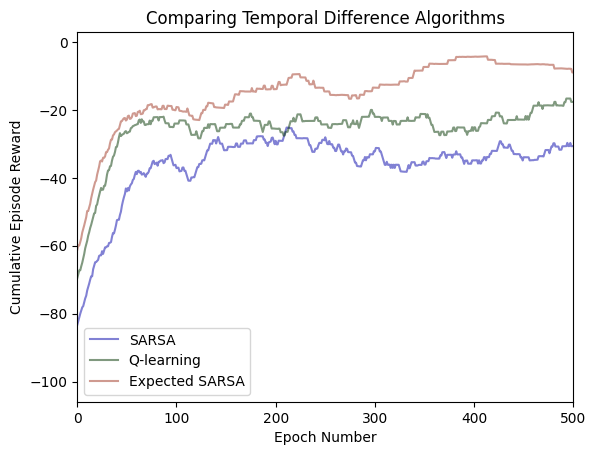

In [60]:
# plt.plot(Exp_SARSA_rewards, '-', color='xkcd:brick', label='Expected SARSA', alpha=0.5)
plt.plot(SMA(SARSA_rewards, size=100), '-', color='xkcd:royal blue', label='SARSA', alpha=0.5)
plt.plot(SMA(QLearning_rewards, size=100), '-', color='xkcd:dark green', label='Q-learning', alpha=0.5)
plt.plot(SMA(Exp_SARSA_rewards, size=100), '-', color='xkcd:brick', label='Expected SARSA', alpha=0.5)
# plt.ylim(-300,0)
plt.xlim(0,500)
plt.title('Comparing Temporal Difference Algorithms')
plt.xlabel('Epoch Number')
plt.ylabel('Cumulative Episode Reward')
plt.legend()
plt.savefig('Results/part_d_comparing_TD_incExpSARSA.png', bbox_inches='tight')
plt.show()

# Plotting

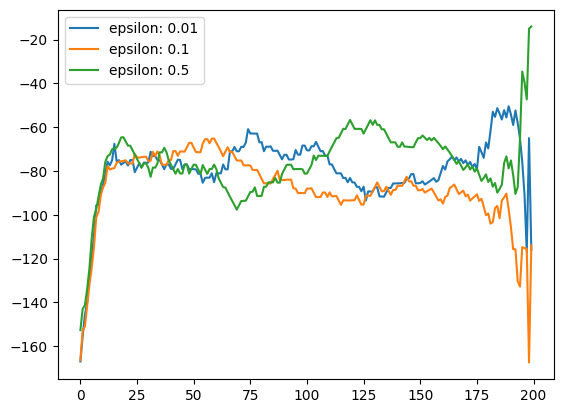

In [123]:
# Qlearning_rewards

for i in range(3): # alpha = 0.5 is constant for epsilon in (0.01, 0.1, 0.5)
    const_alpha_rewards = list(Qlearning_rewards.values())[i]
    key = list(Qlearning_rewards.keys())[i]
    epsilon = key.split(', ')[1]
    plt.plot(const_alpha_rewards, label=epsilon)

plt.legend()
plt.show()

In [ ]:
# SARSA_rewards_2

In [ ]:
# ESARSA_rewards